# Import Libraries and Load Data 

In [1]:
from Libraries import *

In [2]:
df = pd.read_csv(r'zillow_data.csv')
df.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900


In [3]:
florida_data = df[df['State'] == 'FL']

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn import metrics
import warnings
from statsmodels.tsa.stattools import adfuller
from numpy import log
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=13,8

def clean_df_zipcode_index(dataframe):
    fl_df = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df.set_index('Zipcode', inplace=True)
    return fl_df

def clean_df_int_index(dataframe):    
    fl_df_ = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df_.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df_ = fl_df_.reset_index(drop=True)
    return fl_df_

def clean_dict(dataframe):
    fl_dict = dataframe.drop(dataframe.columns[dataframe.columns.str.contains('-')], axis=1)
    fl_dict = fl_dict.drop(['RegionID','SizeRank'], axis=1)
    fl_dict.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_dict = fl_dict.reset_index(drop=True)
    fl_dict = fl_dict.set_index('Zipcode')
    return fl_dict

def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

def melt_data_mean(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def multi_index_df(df):
    df_full = clean_df_int_index(df)
    df_full_melt = melt_data(df_full)
    ts = df_full_melt.set_index('time')
    fl_df_comprehensive = ts.groupby(['Zipcode']).resample('M').sum()
    fl_df_comprehensive = fl_df_comprehensive.drop('Zipcode', axis=1)
    return fl_df_comprehensive

def get_top_cities(dictionary, key):
    for i, j in dictionary.items(): 
        if i in key: 
            top_5_cities.append(j['City'])      

def get_bottom_cities(dictionary, key):
    for i, j in dictionary.items(): 
        if i in key: 
            bottom_5_cities.append(j['City'])

def plot_train_test_pred(train, test, prediction_df):
    fig, ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', color='red')
    ax.plot(prediction_df['prediction'], label='prediction', ls=':', color='black')

    ax.fill_between(x=prediction_df.index, y1=prediction_df['lower'], y2=prediction_df['upper'], ls='-', color='grey', alpha=0.3)

    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout
    return fig, ax

def forecast_to_dataframe(forecast, zipcode):
    test_predictions = forecast.conf_int()
    test_predictions[zipcode] = forecast.predicted_mean
    test_predictions.columns = ['lower','upper','prediction']
    return test_predictions

### Clean and Restructure Data 

In [5]:
fl_df_comprehensive = multi_index_df(florida_data)

fl_df_comprehensive.head()

value
Zipcode time                
32003   1996-04-30  135500.0
        1996-05-31  136000.0
        1996-06-30  136700.0
        1996-07-31  137700.0
        1996-08-31  139000.0

In [6]:
reset = fl_df_comprehensive.reset_index(level=0)

reset.head(3)

,Zipcode,value
time,,
1996-04-30,32003,135500.0
1996-05-31,32003,136000.0
1996-06-30,32003,136700.0


In [7]:
dict_df = clean_dict(florida_data)

fl_dict_names = dict_df.to_dict(orient='index')

print(list(fl_dict_names)[0:5])

[32162, 33160, 33025, 33411, 33139]


In [8]:
zipcode_list_ = reset['Zipcode'].unique().tolist()

time_series_dict = {}

for zipcode in zipcode_list_:
    temp_series = reset.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    time_series_dict[zipcode] = temp_series

In [9]:
test_zip = 32003
time_series_dict[test_zip]

time
1996-04-30    135500.0
1996-05-31    136000.0
1996-06-30    136700.0
1996-07-31    137700.0
1996-08-31    139000.0
                ...   
2017-12-31    271300.0
2018-01-31    272800.0
2018-02-28    273400.0
2018-03-31    274300.0
2018-04-30    275300.0
Name: value, Length: 265, dtype: float64

In [10]:
final_df = pd.DataFrame(time_series_dict)
final_df.dropna(axis=1, inplace=True)
final_df.head()

zipcode_list = final_df.columns.tolist()

# Data Preprocessing

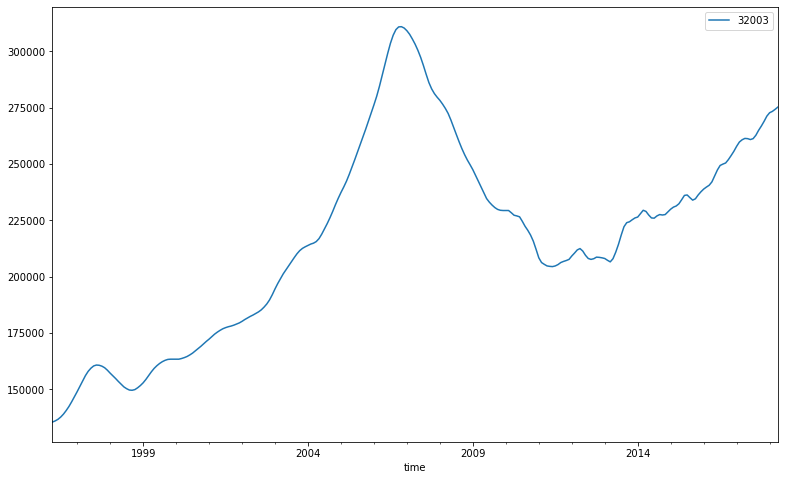

In [11]:
test_series = final_df[test_zip].copy()
ax = test_series.plot()
ax.legend()

### Check ACF/PACF for Test Series

#### Autocorrelation Function 

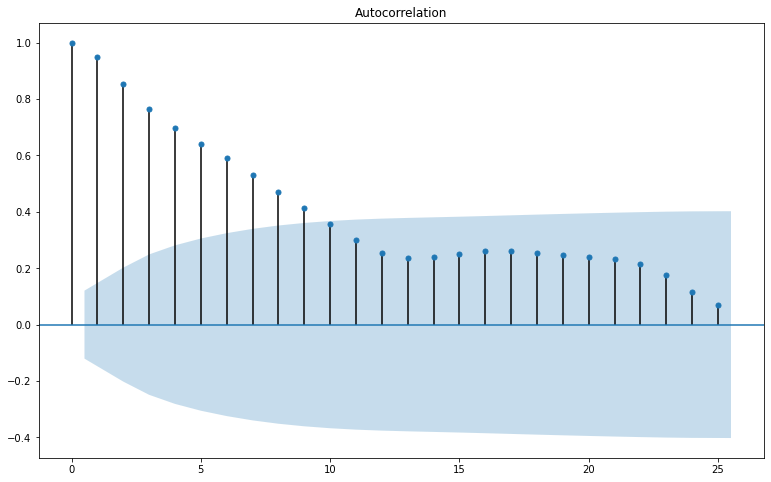

In [12]:
plot_acf(test_series.diff(1).dropna());

#### Partial Autocorrelation Function

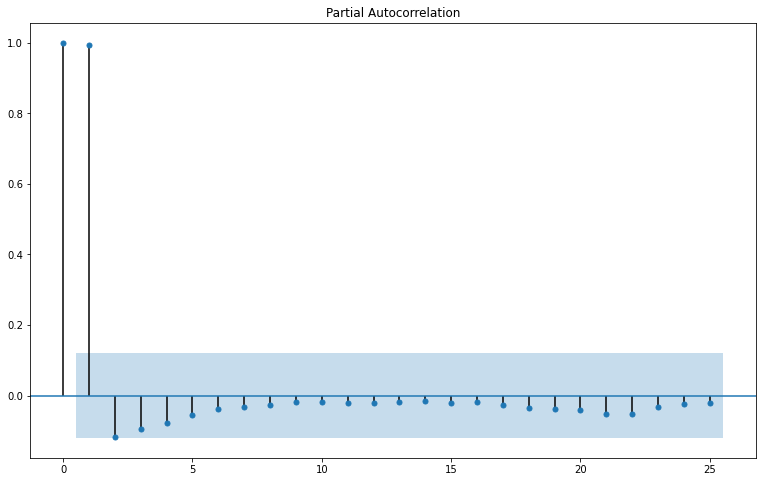

In [13]:
plot_pacf(test_series.dropna());

### Create Training and Testing Sets for Test Series

In [14]:
train_pct = 0.8
split_index = round(len(test_series)*train_pct)
split_index

212

In [15]:
train = test_series.iloc[:split_index]
test = test_series.iloc[split_index:]

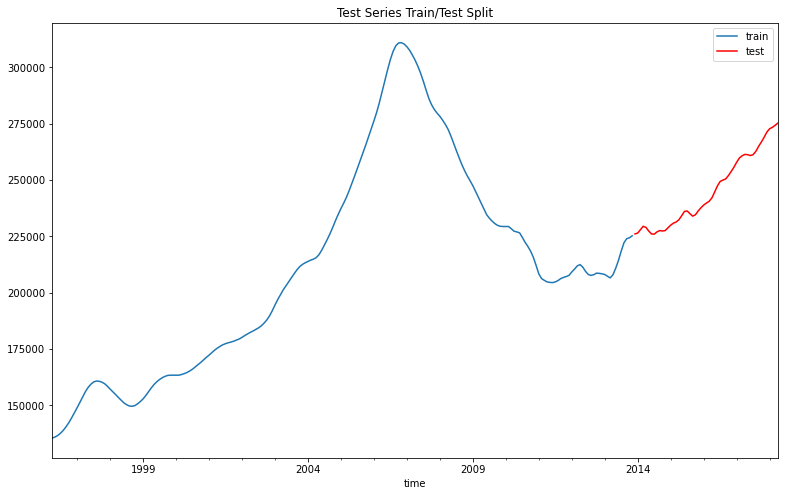

In [16]:
fig, ax = plt.subplots()
train.plot(label='train')
test.plot(label='test', color='red')
plt.title('Test Series Train/Test Split')
ax.legend();

# ARIMA Modeling

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1862.077
Date:                Wed, 23 Dec 2020   AIC                           3730.154
Time:                        02:15:26   BIC                           3740.209
Sample:                    04-30-1996   HQIC                          3734.218
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9068      0.023     38.926      0.000       0.861       0.952
ma.L1         -0.8573      0.027    -32.275      0.000      -0.909      -0.805
sigma2      2.461e+06   6.56e-10   3.75e+15      0.000    2.46e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      848.41   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               1.47   Skew:                            -0.28
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+31. Standard errors may be unstable.
"""

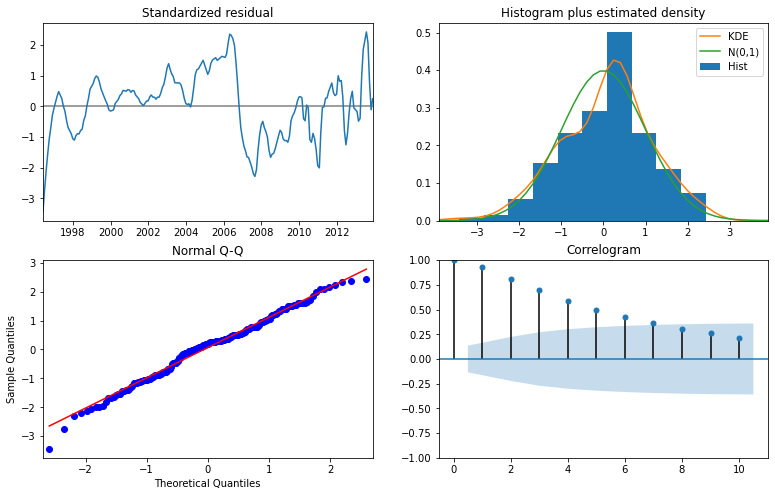

In [17]:
# Optimal hyperparameters using AIC minimum
p = 1
d = 1
q = 1

model = SARIMAX(train, order=(p,d,q)).fit()

display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1597.889
Date:                Wed, 23 Dec 2020   AIC                           3199.778
Time:                        02:15:27   BIC                           3206.472
Sample:                             0   HQIC                          3202.484
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.009      5.532      0.000       0.031       0.065
sigma2      2.291e+05    1.3e+04     17.632      0.000    2.04e+05    2.55e+05
===================================================================================
Ljung-Box (Q):                      167.15   Jarque-Bera (JB):               124.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.51   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

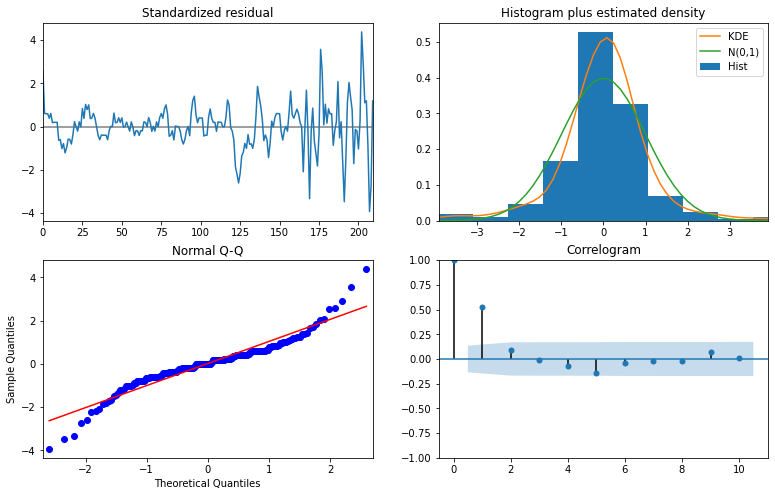

In [18]:
auto_arima_model = auto_arima(train, start_p=0, start_q=0)
display(auto_arima_model.summary())
auto_arima_model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2036.985
Date:                Wed, 23 Dec 2020   AIC                           4077.970
Time:                        02:15:27   BIC                           4085.114
Sample:                    04-30-1996   HQIC                          4080.841
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0466      0.008      5.692      0.000       0.031       0.063
sigma2      3.034e+05   1.78e+04     17.010      0.000    2.68e+05    3.38e+05
===================================================================================
Ljung-Box (Q):                      164.34   Jarque-Bera (JB):                61.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

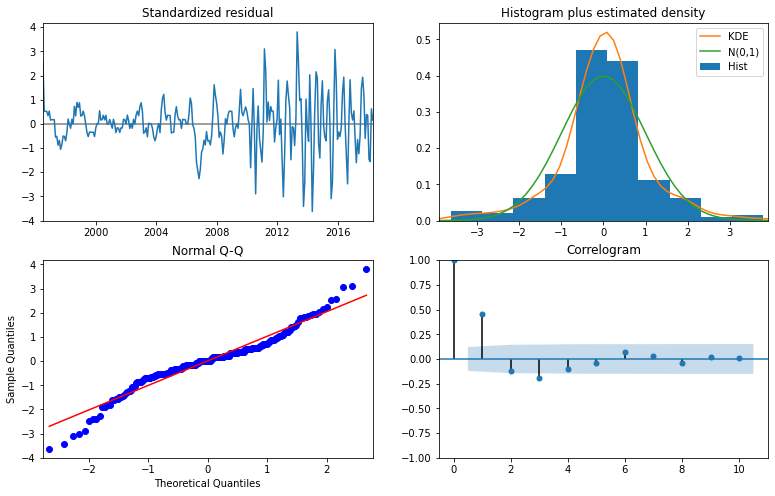

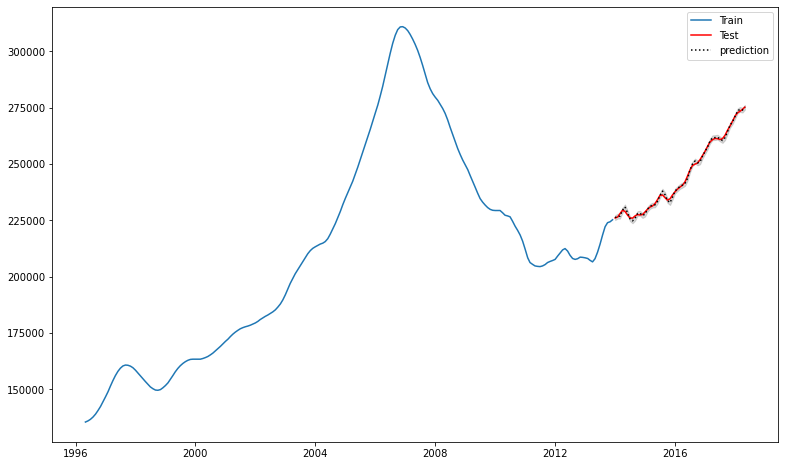

In [19]:
best_model = SARIMAX(test_series, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()

display(best_model.summary())
best_model.plot_diagnostics()

prediction_best_model = best_model.get_prediction(start=test.index[0], end=test.index[-1])

prediction_df = forecast_to_dataframe(prediction_best_model, test_zip)

plot_train_test_pred(train, test, prediction_df);

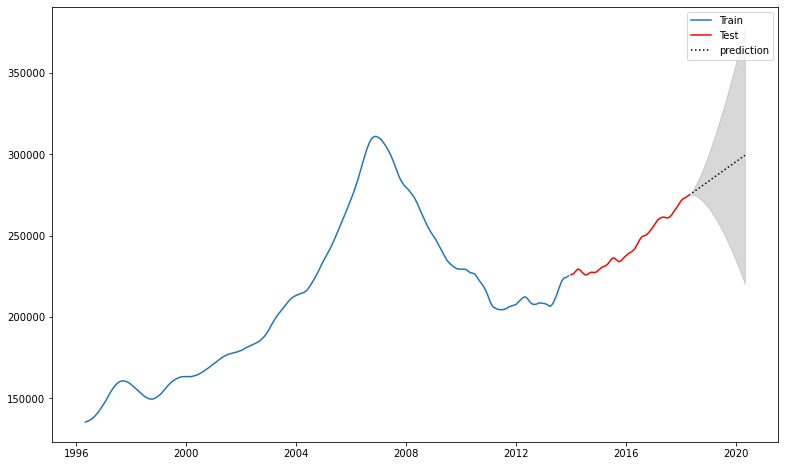

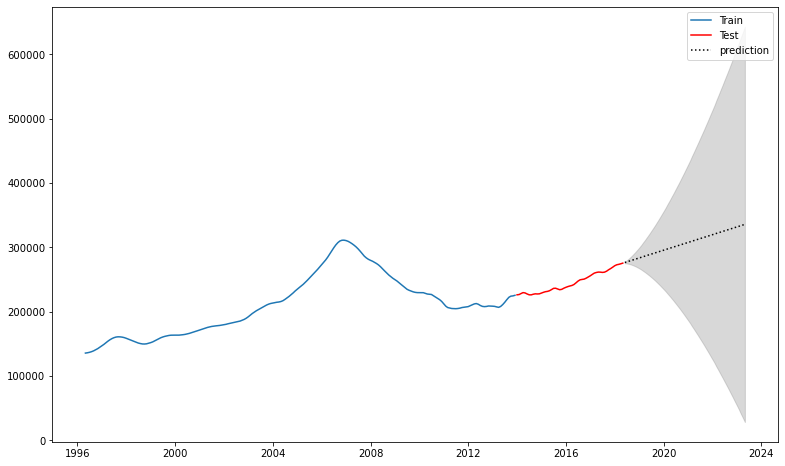

In [20]:
pred_2yr = best_model.get_forecast(steps=24)
pred_5yr = best_model.get_forecast(steps=60)

pred_2yr_df = forecast_to_dataframe(pred_2yr, test_zip)
pred_5yr_df = forecast_to_dataframe(pred_5yr, test_zip)

plot_train_test_pred(train, test, pred_2yr_df)
plot_train_test_pred(train, test, pred_5yr_df);

In [21]:
results = {}

for zipcode in zipcode_list:
    
    zipcode_dict = {}
    
    fl_time_series = final_df[zipcode].copy()
    
    # train/test split
    train_pct = 0.8
    split_index = round(len(fl_time_series)*train_pct)
    split_index
    
    train_ = fl_time_series.iloc[:split_index]
    test_ = fl_time_series.iloc[split_index:]
    
    
    model_ = SARIMAX(test_, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()
    
    zipcode_dict['train'] = train_
    zipcode_dict['test'] = test_
    zipcode_dict['model'] = model_
    
    pred_2yrs = model_.get_forecast(steps=24)
    pred_2yrs_df = forecast_to_dataframe(pred_2yrs, zipcode)
    zipcode_dict['upper'] = pred_2yrs_df['upper']
    zipcode_dict['lower'] = pred_2yrs_df['lower']
    zipcode_dict['prediction'] = pred_2yrs_df['prediction']
    
    results[zipcode] = zipcode_dict


In [22]:
results_5yr = {}

for zipcode in zipcode_list:
    
    zipcode_dict_5yr = {}
    
    fl_time_series_ = final_df[zipcode].copy()
    
    # train/test split
    train_pct = 0.8
    split_index = round(len(fl_time_series_)*train_pct)
    split_index
    
    train_5yr = fl_time_series_.iloc[:split_index]
    test_5yr = fl_time_series_.iloc[split_index:]
    
    
    model_5yr = SARIMAX(test_5yr, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()
    
    zipcode_dict_5yr['train'] = train_5yr
    zipcode_dict_5yr['test'] = test_5yr
    zipcode_dict_5yr['model'] = model_5yr
    
    pred_5yrs = model_5yr.get_forecast(steps=60)
    pred_5yrs_df = forecast_to_dataframe(pred_5yrs, zipcode)
    zipcode_dict_5yr['upper'] = pred_5yrs_df['upper']
    zipcode_dict_5yr['lower'] = pred_5yrs_df['lower']
    zipcode_dict_5yr['prediction'] = pred_5yrs_df['prediction']
    
    results_5yr[zipcode] = zipcode_dict_5yr

In [23]:
returns_list_5yr = []

for zipcode in results_5yr:
    pct_change = (results_5yr[zipcode]['prediction'][-1] - results_5yr[zipcode]['test'][-1]) / (results_5yr[zipcode]['test'][-1]) * (100)
    returns_list_5yr.append((pct_change, zipcode))

In [24]:
returns_list = []

for zipcode in results:
    pct_change = (results[zipcode]['prediction'][-1] - results[zipcode]['test'][-1]) / (results[zipcode]['test'][-1]) * (100)
    returns_list.append((pct_change, zipcode))

In [25]:
returns_list_max = []

for zipcode in results:
    pct_change = (results[zipcode]['upper'][-1] - results[zipcode]['train'][0]) / (results[zipcode]['train'][0]) * (100)
    returns_list_max.append((zipcode, pct_change))

In [26]:
returns_list_min = []

for zipcode in results:
    pct_change = (results[zipcode]['lower'][-1] - results[zipcode]['train'][0]) / (results[zipcode]['train'][0]) * (100)
    returns_list_min.append((zipcode, pct_change))

In [27]:
sorted(returns_list_5yr, reverse=True)

#sorted(returns_list, reverse=True)

[32320, 33701, 33704, 32680, 33181]

[32320, 33701, 33704, 32680, 33181]

In [28]:
returns = pd.DataFrame(returns_list, columns=['return','zip'])
returns_max = pd.DataFrame(returns_list_max, columns=['zip','return_max'])
returns_min = pd.DataFrame(returns_list_min, columns=['zip','return_min'])
returns_5yr = pd.DataFrame(returns_list_5yr, columns=['return','zip'])

returns_5yr.to_csv('returns_5yr.csv')
returns.to_csv('returns.csv')
returns_max.to_csv('returns_max.csv')
returns_min.to_csv('returns_min.csv')

returns_max.head()
returns.head()

,return,zip
0,8.705691,32003
1,43.492598,32008
2,17.928997,32009
3,35.306831,32011
4,4.667238,32024


#### Top 5 Two Year Plots 

<Figure size 936x576 with 0 Axes>

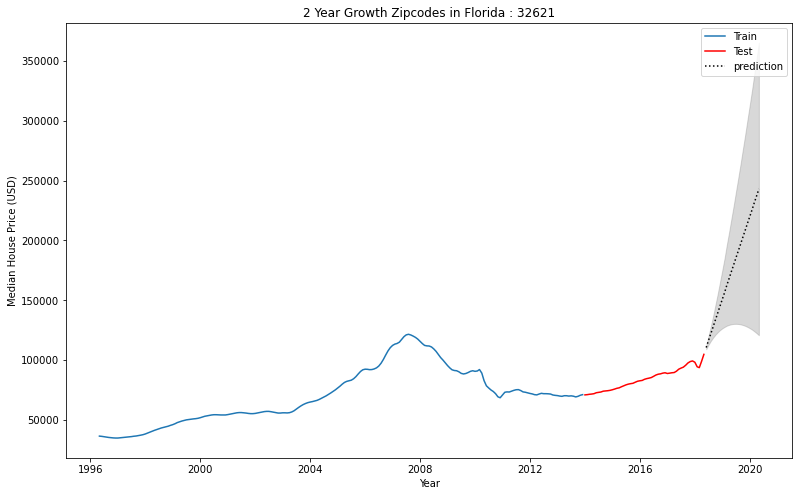

<Figure size 936x576 with 0 Axes>

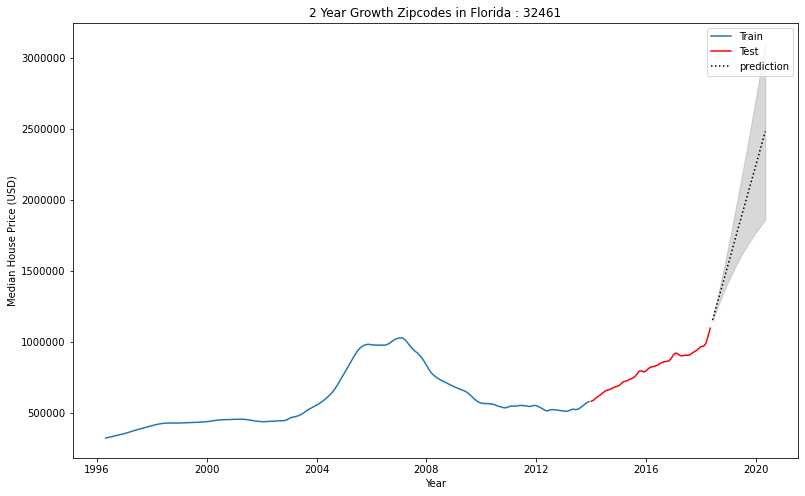

<Figure size 936x576 with 0 Axes>

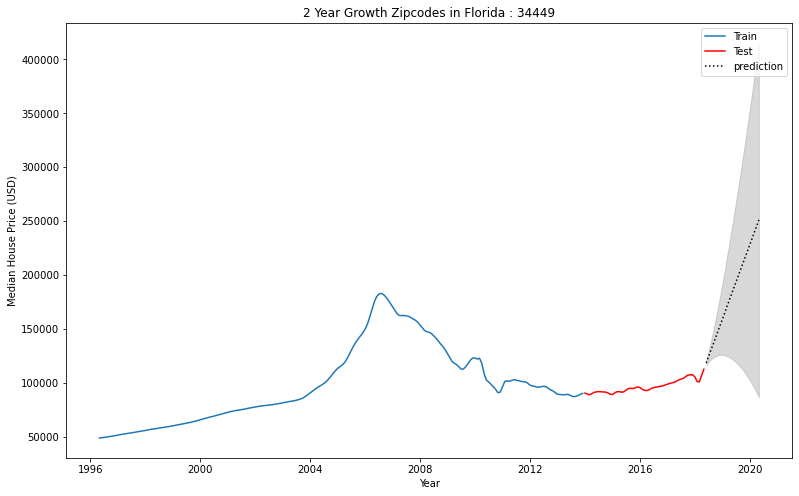

<Figure size 936x576 with 0 Axes>

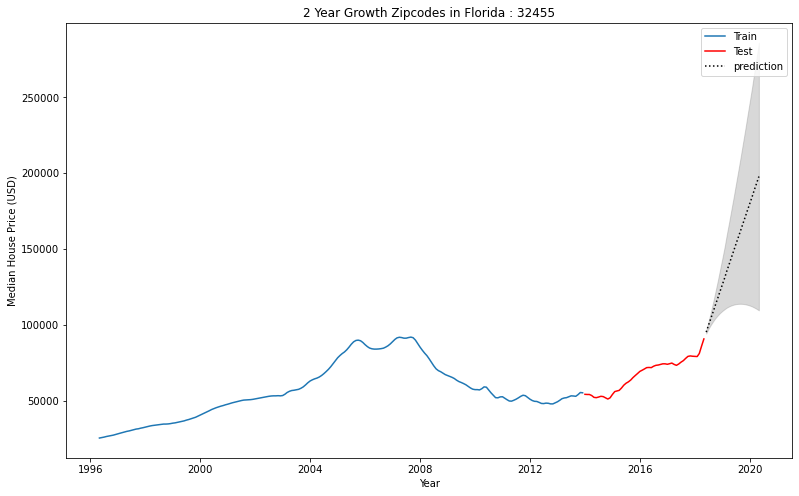

<Figure size 936x576 with 0 Axes>

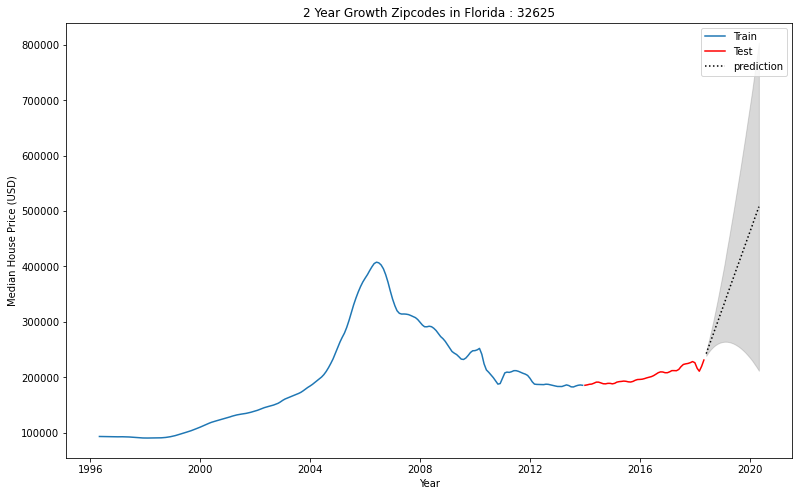

In [29]:
top_5_zips = [32621, 32461, 34449, 32455, 32625]


for _zipcode_ in top_5_zips:
    
    plt.figure()
    model = SARIMAX(final_df[_zipcode_], order=auto_arima_model.order,
                    seasonal_order=auto_arima_model.seasonal_order).fit()
    
    train__ = final_df[_zipcode_].iloc[:split_index]
    test__ = final_df[_zipcode_].iloc[split_index:]
    predict_2yr = model.get_forecast(steps=24)
    predict_2yr_df = forecast_to_dataframe(predict_2yr, _zipcode_)
    plot_train_test_pred(train__, test__, predict_2yr_df)
    
    plt.title('2 Year Growth Zipcodes in Florida : {}'.format(_zipcode_))
    plt.xlabel('Year')
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylabel('Median House Price (USD)');

#### Top 5 Five Year Plots 

<Figure size 936x576 with 0 Axes>

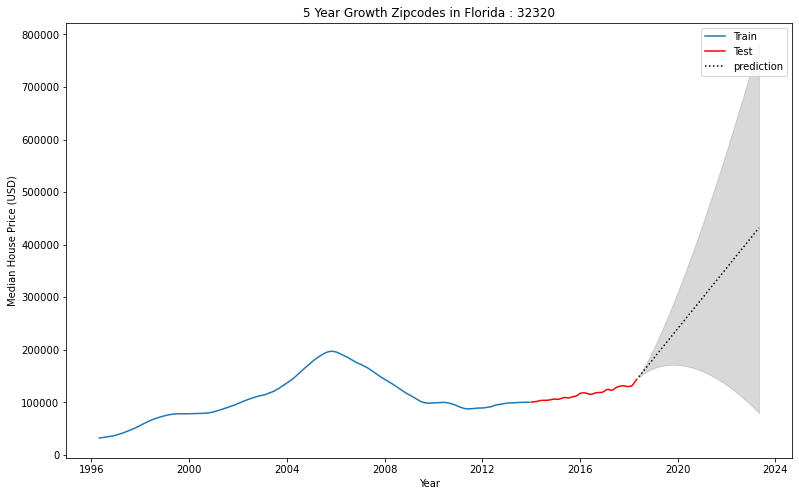

<Figure size 936x576 with 0 Axes>

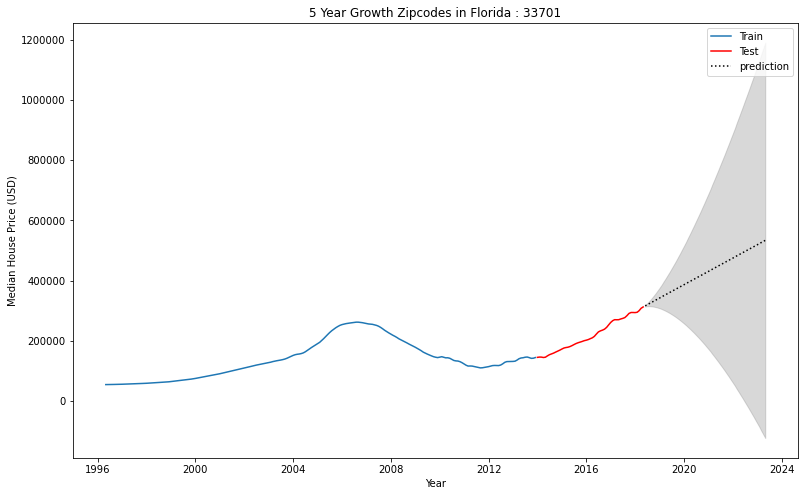

<Figure size 936x576 with 0 Axes>

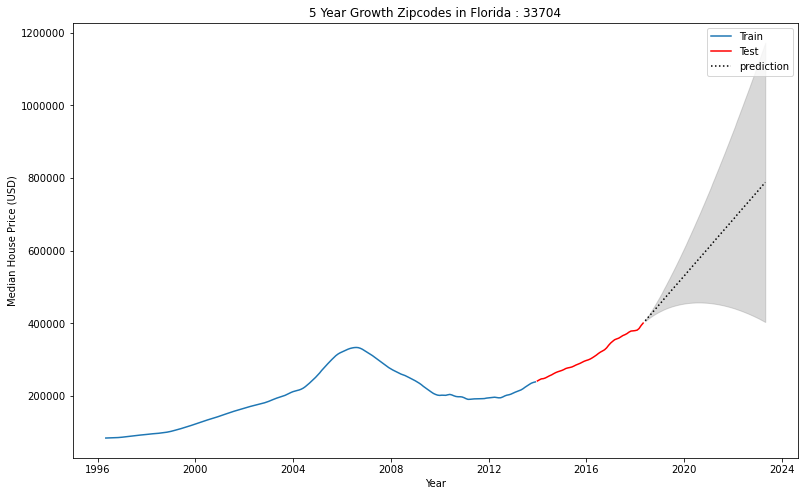

<Figure size 936x576 with 0 Axes>

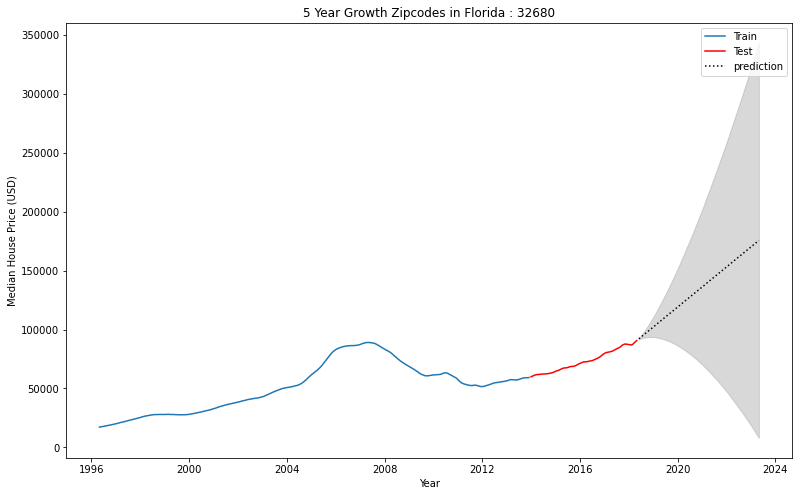

<Figure size 936x576 with 0 Axes>

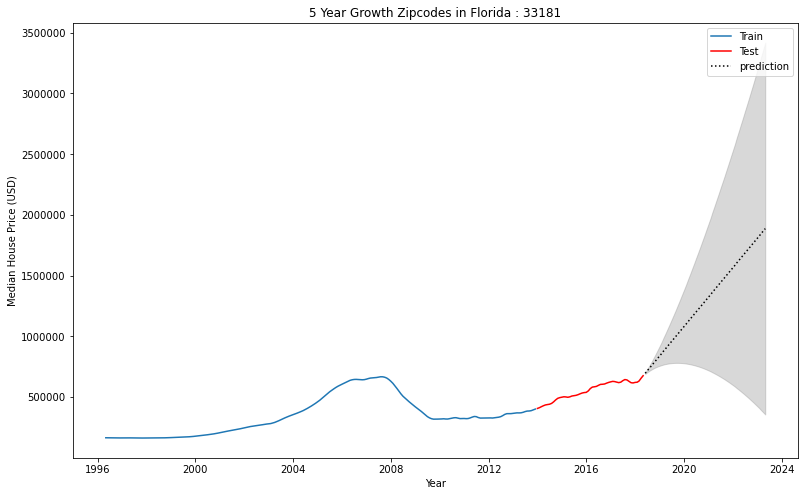

In [30]:
top_5_zips_5yr = [32320, 33701, 33704, 32680, 33181]


for zipcode__ in top_5_zips_5yr:
    
    plt.figure()
    model = SARIMAX(final_df[zipcode__], order=auto_arima_model.order,
                    seasonal_order=auto_arima_model.seasonal_order).fit()
    
    train = final_df[zipcode__].iloc[:split_index]
    test = final_df[zipcode__].iloc[split_index:]
    predict_5yr = model.get_forecast(steps=60)
    predict_5yr_df = forecast_to_dataframe(predict_5yr, zipcode__)
    plot_train_test_pred(train, test, predict_5yr_df)
    
    plt.title('5 Year Growth Zipcodes in Florida : {}'.format(zipcode__))
    plt.xlabel('Year')
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylabel('Median House Price (USD)');

## ARIMA Modeling with All Zipcodes

In [31]:
fuller_df = melt_data_mean(clean_df_int_index(florida_data))
result = adfuller(fuller_df['value'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

fuller_df.head()

ADF Statistic: -1.630457
p-value: 0.467252


,value
time,
1996-04-01,104529.019608
1996-05-01,104594.117647
1996-06-01,104662.352941
1996-07-01,104727.058824
1996-08-01,104816.993464


In [32]:
train_fuller = fuller_df['value'].iloc[:split_index]
test_fuller = fuller_df['value'].iloc[split_index:]

In [33]:
fuller_df.head()

,value
time,
1996-04-01,104529.019608
1996-05-01,104594.117647
1996-06-01,104662.352941
1996-07-01,104727.058824
1996-08-01,104816.993464


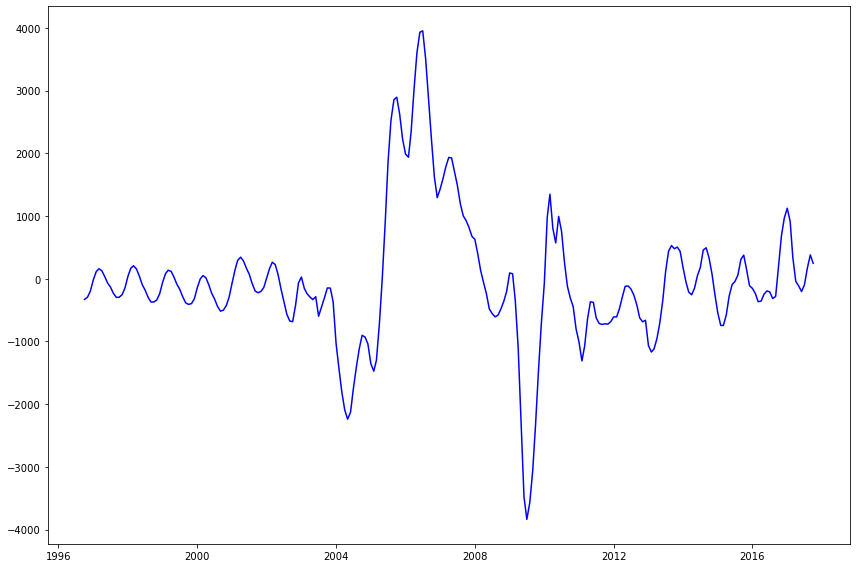

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = sm.tsa.seasonal_decompose(fuller_df, model='additive')

residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.plot(residual, label='Residuals', color='blue')
plt.tight_layout()

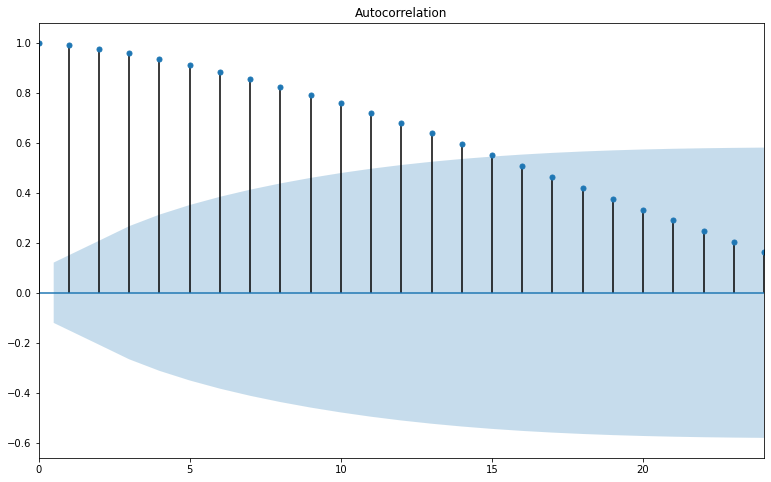

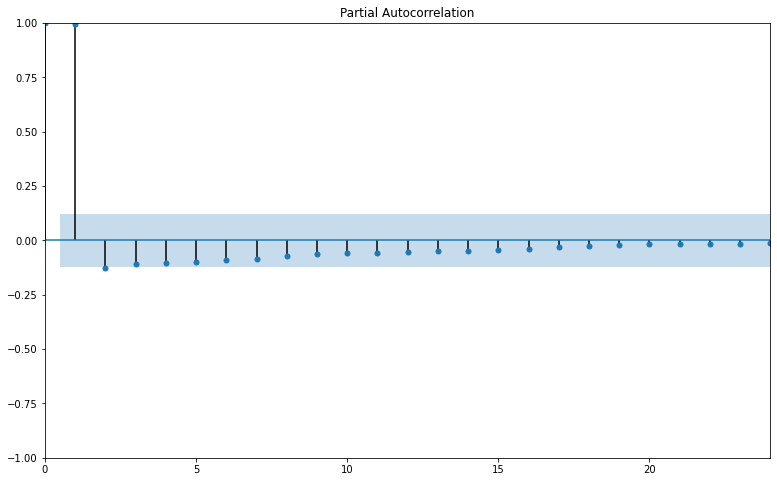

In [35]:
rcParams['figure.figsize']=13,8

plot_acf(fuller_df.diff(periods=1).dropna()); plt.xlim(0,24); plt.show()
plot_pacf(fuller_df); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

In [36]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [37]:
ans = []
for combination in pdq:
    for combinations in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(fuller_df,
                                            order=combination,
                                            seasonal_order=combinations,
                                            approx=False,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([combination, combinations, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combination, combinations, output.aic))
        except:
            continue

ans

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7216.813041412668
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6733.7645058405105
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5875.0030664264405
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5608.11919836012
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5887.494035942432
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5800.882024499652
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5440.736229581077
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5420.7592879807835
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6999.017677781154
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6636.963908232914
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5864.292163593193
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8211.80909495856
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7081.379747784174
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6619.570142541327
ARIMA (0, 0, 1) x (

[[(0, 0, 0), (0, 0, 0, 12), 7216.813041412668],
 [(0, 0, 0), (0, 0, 1, 12), 6733.7645058405105],
 [(0, 0, 0), (0, 1, 0, 12), 5875.0030664264405],
 [(0, 0, 0), (0, 1, 1, 12), 5608.11919836012],
 [(0, 0, 0), (1, 0, 0, 12), 5887.494035942432],
 [(0, 0, 0), (1, 0, 1, 12), 5800.882024499652],
 [(0, 0, 0), (1, 1, 0, 12), 5440.736229581077],
 [(0, 0, 0), (1, 1, 1, 12), 5420.7592879807835],
 [(0, 0, 1), (0, 0, 0, 12), 6999.017677781154],
 [(0, 0, 1), (0, 0, 1, 12), 6636.963908232914],
 [(0, 0, 1), (0, 1, 0, 12), 5864.292163593193],
 [(0, 0, 1), (0, 1, 1, 12), 8211.80909495856],
 [(0, 0, 1), (1, 0, 0, 12), 7081.379747784174],
 [(0, 0, 1), (1, 0, 1, 12), 6619.570142541327],
 [(0, 0, 1), (1, 1, 0, 12), 5830.77698804295],
 [(0, 0, 1), (1, 1, 1, 12), 7641.211934148969],
 [(0, 1, 0), (0, 0, 0, 12), 4833.982590907675],
 [(0, 1, 0), (0, 0, 1, 12), 4447.92057885861],
 [(0, 1, 0), (0, 1, 0, 12), 4486.294703872583],
 [(0, 1, 0), (0, 1, 1, 12), 4266.67334411157],
 [(0, 1, 0), (1, 0, 0, 12), 4468.465800030

In [38]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3430.72
Name: 63, dtype: object

In [39]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(fuller_df, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9800      0.011     89.725      0.000       0.959       1.001
ma.L1          0.3312      0.019     17.501      0.000       0.294       0.368
ar.S.L12      -0.4731      0.060     -7.853      0.000      -0.591      -0.355
ma.S.L12      15.0582      4.951      3.041      0.002       5.355      24.762
sigma2       412.2228    272.184      1.515      0.130    -121.248     945.693


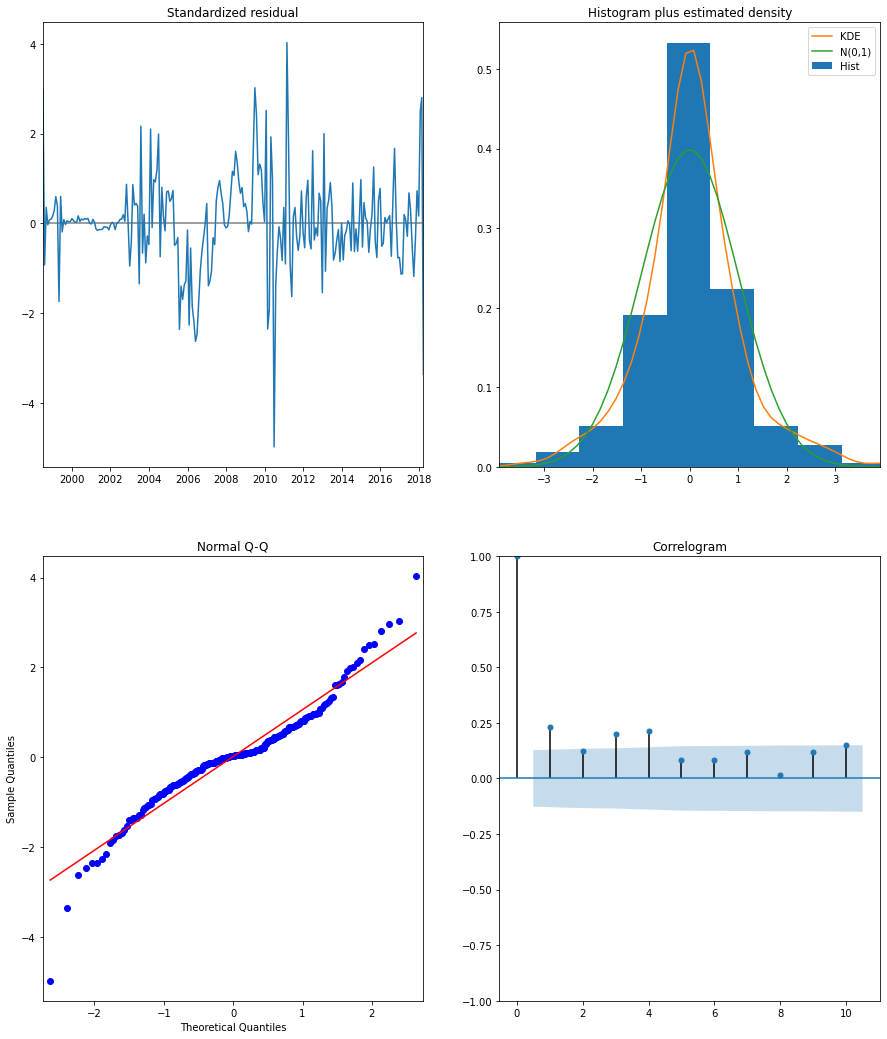

In [40]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [41]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [42]:
prediction = output.get_forecast(steps=24)
prediction_5yr = output.get_forecast(steps=60)

pred_conf = prediction.conf_int( )
pred_conf_5yr = prediction_5yr.conf_int()

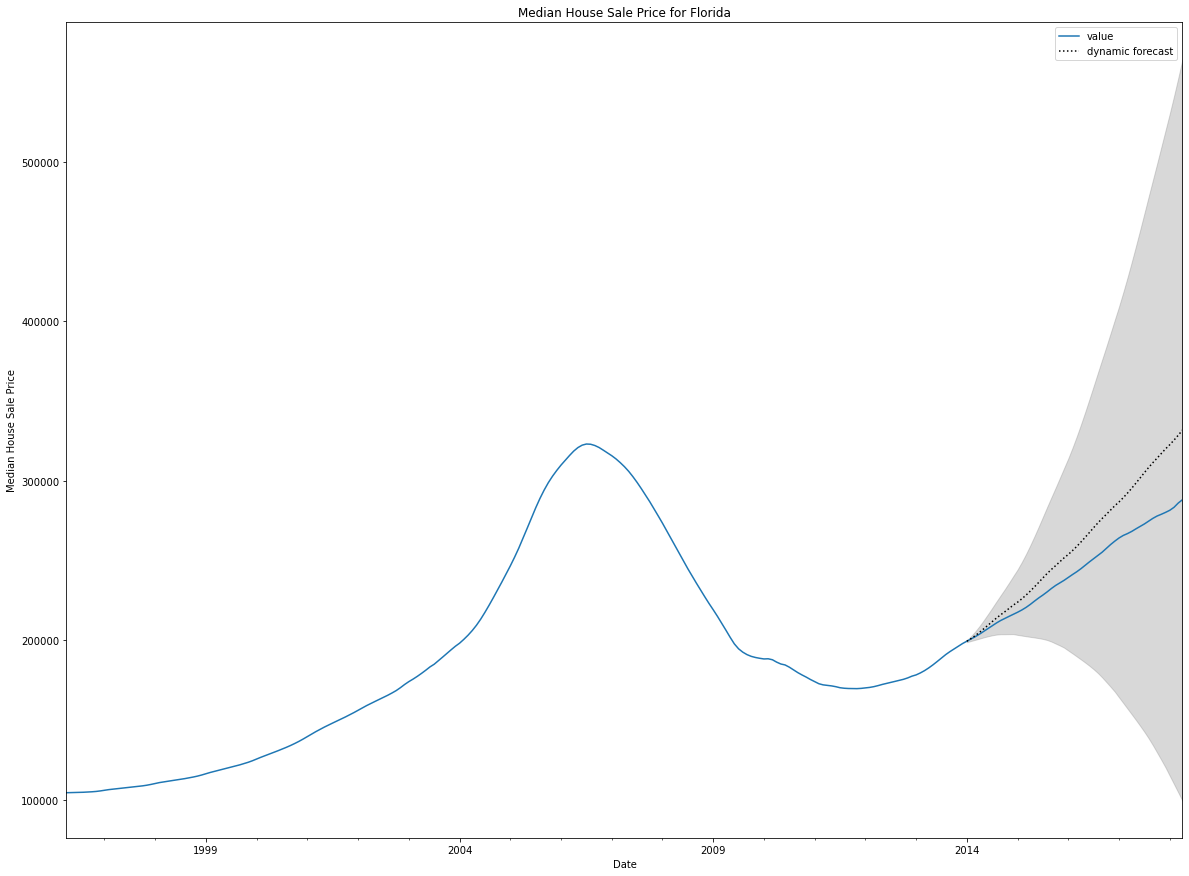

In [43]:
ax = fuller_df['1996-04-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='dynamic forecast', ax=ax, ls=':', color='black')

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='grey', alpha=.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

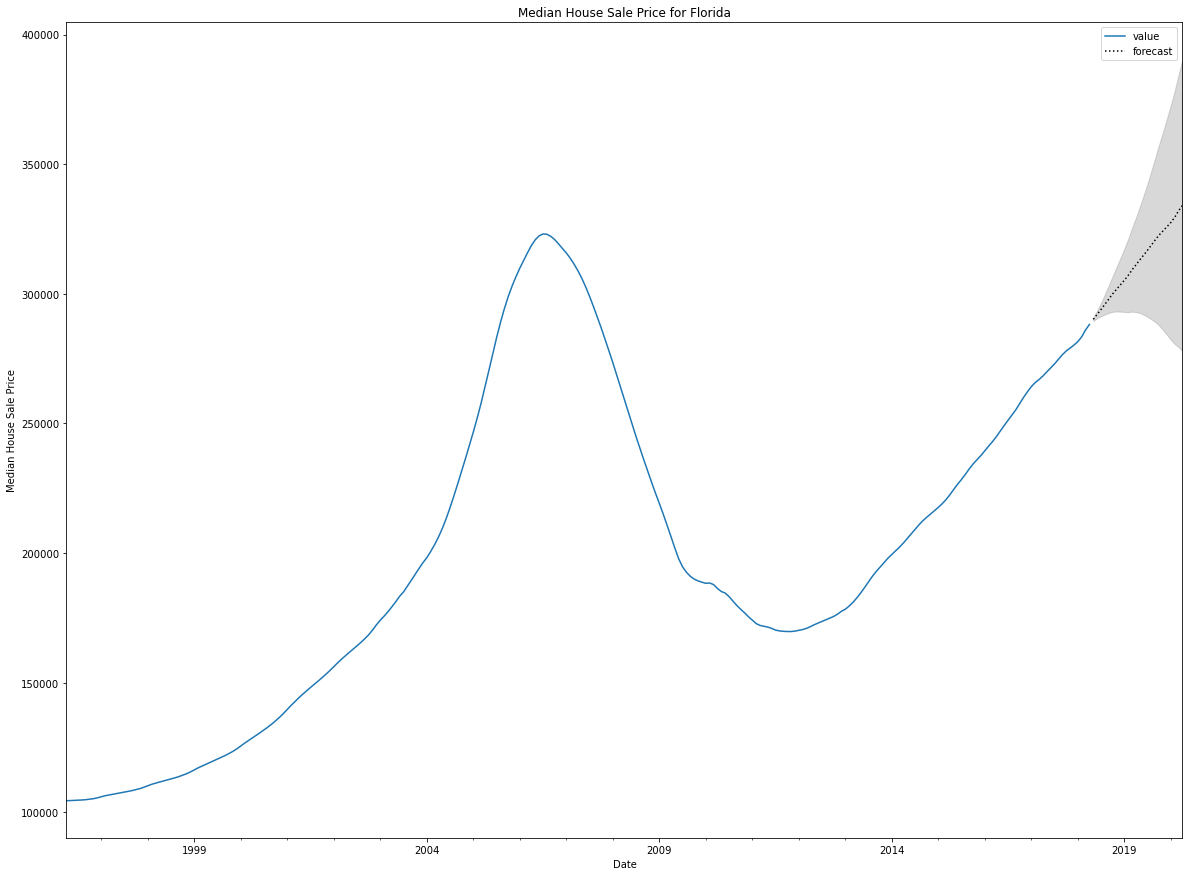

In [44]:
ax = fuller_df.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='forecast', color='black', ls=':')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

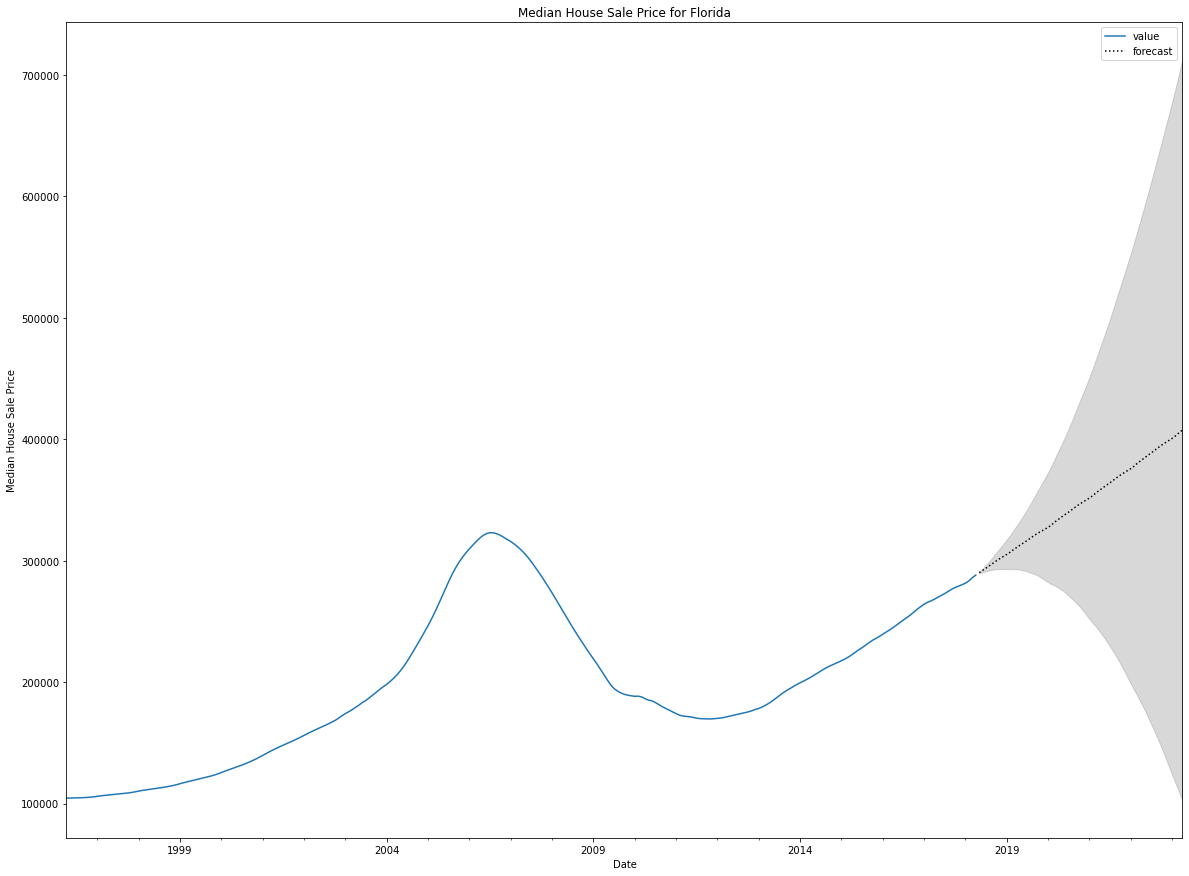

In [45]:
# Plot future predictions with confidence intervals
ax = fuller_df.plot(label='observed', figsize=(20, 15))
prediction_5yr.predicted_mean.plot(ax=ax, label='forecast', color='black', ls=':')
ax.fill_between(pred_conf_5yr.index,
                pred_conf_5yr.iloc[:, 0],
                pred_conf_5yr.iloc[:, 1], color='grey', alpha=0.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

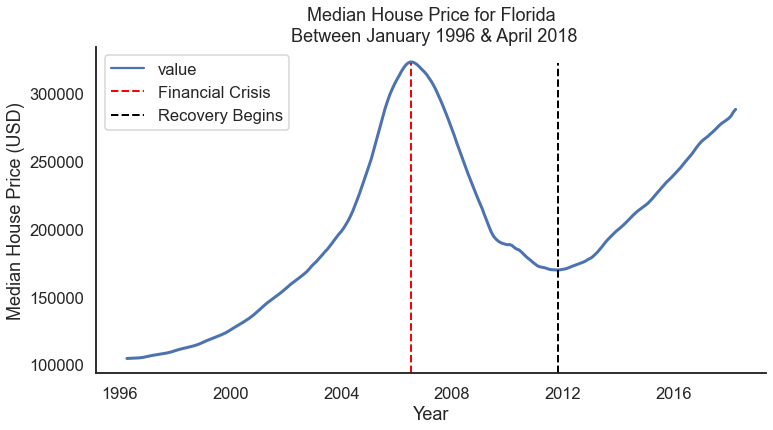

In [46]:
sns.set(rc={'figure.figsize':(12,6)},style="white", context="talk")

ax = sns.lineplot(data=fuller_df, color='g', lw=3);

ax.axvline(x=pd.to_datetime('2006-07-14'), ymin=0, ymax=0.95, ls= "--", lw=2, color='red', label='Financial Crisis')
ax.axvline(x=pd.to_datetime('2011-11-01'), ymin=0, ymax=0.95, ls= "--", lw=2, color='black', label='Recovery Begins')


title = 'Median House Price for Florida\n Between January 1996 & April 2018'
ax.set_title(title)

xlabel = 'Year'
ylabel = "Median House Price (USD)"
ax.set(xlabel=xlabel, ylabel=ylabel)

sns.despine()
plt.legend();

### Historical Plots for Top 5 Zipcodes

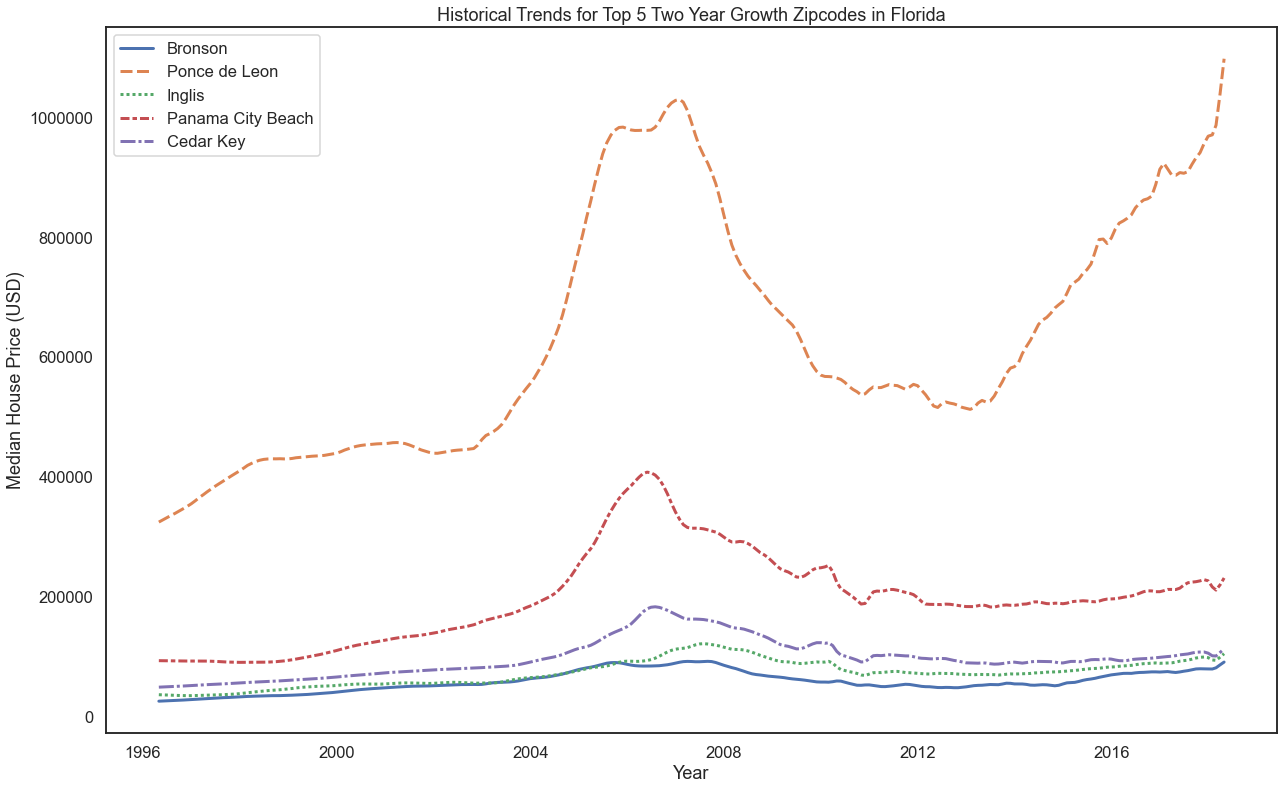

In [47]:
sns.set(rc={'figure.figsize':(21,13)},style="white", context="talk")

sns.lineplot(data=final_df[top_5_zips], lw=3);

top_5_zips = [32621, 32461, 34449, 32455, 32625]

key = final_df[top_5_zips].columns
top_5_cities = []

get_top_cities(fl_dict_names, key)

plt.legend(top_5_cities)

plt.title('Historical Trends for Top 5 Two Year Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)')
plt.ticklabel_format(axis='y', style='plain');


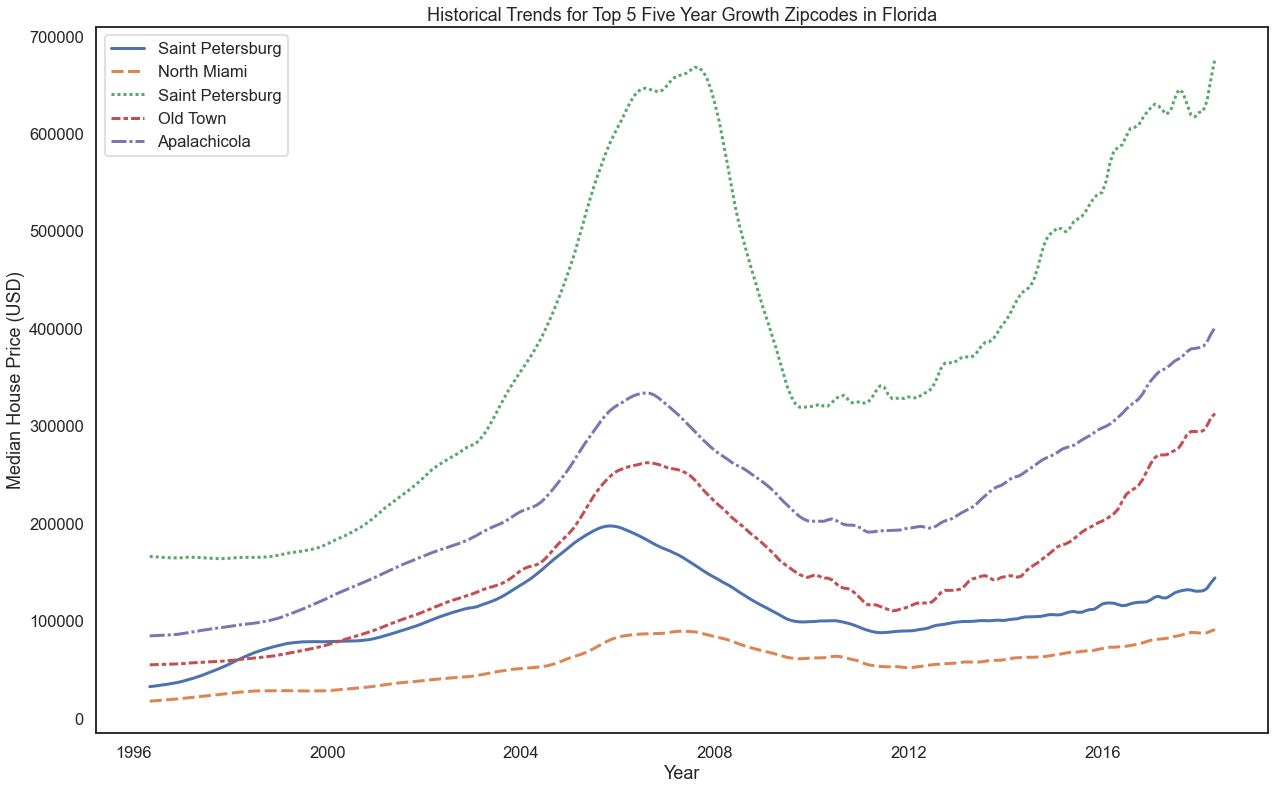

In [48]:
sns.set(rc={'figure.figsize':(21,13)},style="white", context="talk")

top_5_zips_ = [32320, 33701, 33704, 32680, 33181]

sns.lineplot(data=final_df[top_5_zips_], lw=3);

key = final_df[top_5_zips_].columns
top_5_cities = []

get_top_cities(fl_dict_names, key)

plt.legend(top_5_cities)

plt.title('Historical Trends for Top 5 Five Year Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)')
plt.ticklabel_format(axis='y', style='plain');